# Photonic Band Gap, lab report

Notebook con l'analisi dei dati raccolti sull'esperimento della banda fotonica.
I dati sono stati organizzati per data in diverse run (R0, R1, ...) e catalogati nella cartella labeldata.
Di seguito verranno importati tutti i dati che poi verranno nuovamente divisi in sottogruppi di interesse e 
analizzati. 

Da notare che non tutti i campi sono presenti in tutte le misure, questo perché il paradigma di misura è cambiato in opera durante la presa dati.

In [1]:
%load_ext autoreload
%autoreload 1
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.optimize import minimize
%aimport utils
from utils import *
import importlib
%matplotlib inline

# minimal plot style
plt.rcParams['figure.figsize'] = [10, 5]

# globals
prj_path = os.getcwd()
rel_path = 'labeldata'
full_path = os.path.join(prj_path, rel_path)
files = [f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f))]
print(f'importing these files:')
pprint(files, compact=True)

df = pd.concat([pd.read_csv(os.path.join(rel_path, file)) for file in files])
print(f"list of measured samples: {df['sample'].unique()}")

df

importing these files:
['20-06-24_R1.txt', '20-06-24_R10.txt', '20-06-24_R11.txt', '20-06-24_R12.txt',
 '20-06-24_R13.txt', '20-06-24_R14.txt', '20-06-24_R15.txt', '20-06-24_R16.txt',
 '20-06-24_R17.txt', '20-06-24_R18.txt', '20-06-24_R19.txt', '20-06-24_R2.txt',
 '20-06-24_R3.txt', '20-06-24_R4.txt', '20-06-24_R5.txt', '20-06-24_R6.txt',
 '20-06-24_R7.txt', '20-06-24_R8.txt', '20-06-24_R9.txt', '30-05-24_R0.txt',
 '30-05-24_R1.txt', '30-05-24_R2.txt', '30-05-24_R4.txt', '30-05-24_R5.txt',
 '30-05-24_R6.txt', '30-05-24_R7.txt']
list of measured samples: ['PCR' 'SIL' 'BOX' 'AIR' 'CAL']


id  frequency_GHz   peak_mV  sigma_peak_mV  noise_mV  \
0   20-06-24_R1       0.250000   7.12213   1.418710e-02  0.030717   
1   20-06-24_R1       0.333333   7.12213   9.501470e-16  0.179667   
2   20-06-24_R1       0.416667   7.14780   0.000000e+00  0.171667   
3   20-06-24_R1       0.500000   6.82119   0.000000e+00  0.197167   
4   20-06-24_R1       0.583333   6.85554   1.580340e-01  0.170833   
..          ...            ...       ...            ...       ...   
65  30-05-24_R7       5.666670  11.60000            NaN  0.223000   
66  30-05-24_R7       5.750000  13.70000            NaN  0.257000   
67  30-05-24_R7       5.833330  11.60000            NaN  0.223000   
68  30-05-24_R7       5.916670  10.50000            NaN  0.211000   
69  30-05-24_R7       6.000000  12.60000            NaN  0.248000   

    sigma_noise_mV sample antenna  
0         0.001266    PCR      LF  
1         0.001633    PCR      LF  
2         0.002733    PCR      LF  
3         0.001329    PCR      LF  
4         0.010534    PCR      LF  
..             ...    ...     ...  
65             NaN    CAL     CAB  
66             NaN    CAL     CAB  
67             NaN    CAL     CAB  
68             NaN    CAL     CAB  
69             NaN    CAL     CAB  

[1980 rows x 8 columns]

## Analisi della distorsione del segnale

Come prima cosa è opportuno valutare la presenza di artefatti dell'apparato di misura che andranno sottratti dal segnale. 
Sia il generatore che l'analizzatore danno delle risposte diverse a diverse frequenze, ad esempio il generatore produce un segnale più intenso a basse frequenze, e così via. Ci sono anche gli effetti prodotti dalla scatola con la schermatura, essa produce delle onde stazionarie e delle risonanze che si sommano all'effetto del cristallo fotonico.
In particolare l'analisi del rumore deve tenere conto di:

- distorsioni del generatore e del ricevitore in presa diretta (CAL)
- effetti dovuti alla configurazione reciproca in aria dell'antenna e ricevitore (AIR)
- onde stazionarie dovute alla presenza dell'apparato di schermamento (BOX)

Cominciamo quindi dall'analisi di queste due per capire i loro effetti

Dal grafico "Generator \ Reciever distortion" emerge che il segnale non ha lo stesso gain su tutta la banda, andrà quindi rinormalizzato per eliminare l'amplificazione del segnale da parte dei trasmettitori in questo modo:

$$
 normalized\_signal = \frac{signal}{cal\_signal - cal\_noise}
$$

Lo scopo dell'esperimento non è misurare la potenza effettiva del segnale, ma capire l'effetto del cristallo fotonico nella propagazione di quest'ultimo. 
Possiamo quindi rimuovere il rumore in una prima parte dell'analisi e poi procedere al confronto con un particolare set di misure rinormalizzando i dati.
Il paradigma che vogliamo seguire è il seguente:

1. Rimozione del rumore dal segnale
    - Gain effects
    - Artefatti periodici (da dove derivano?)
    - Dipendenza delle misure dal tempo
1. Analisi dati normalizzando su un campione di confronto

Per eliminare effetti dovuti alle fluttuazioni del segnale sarebbe da interpolare il gain con una funzione continua. Per motivi di semplicità si è scelto di usare un polinomio di secondo grado come approssimante. 
A questo punto vogliamo anche valutare qual'è lo spettro della misura, corretto per il gain, in diverse configurazioni via via più complesse, confrontandole due a due in modo da ricostruire gli effetti che ha cambiare qualcosa:

1. spettro intensità in aria
1. spettro con scatola di contenimento vuota (sarà importante per i successivi confronti)
1. spettro con silicio a varie altezze 
1. spettro con cristallo fotonico

## Analisi del rumore e gain 
Come prima cosa facciamo il fit del segnale del gain:

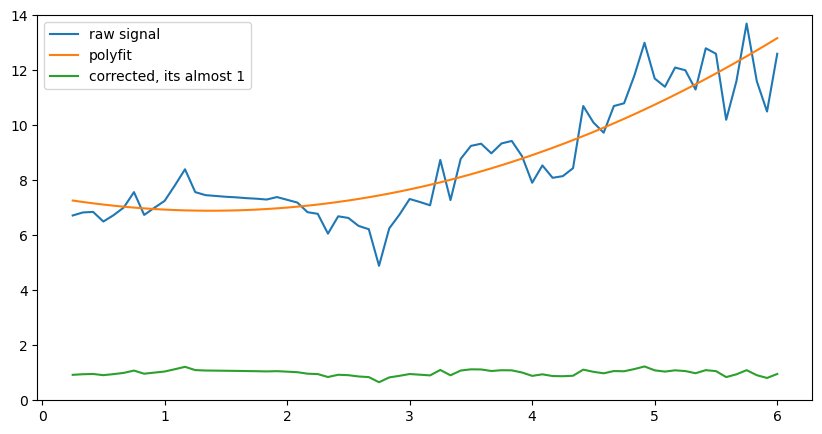

In [2]:
def getGain():
    '''
        Get the gain for each frequency by interpolating
        the measures as a polynomial
    '''
    subset = df[df['sample'] == 'CAL']
    x = subset['frequency_GHz'].values.tolist()
    y = subset['peak_mV'].values.tolist()
    coeff = np.polyfit(x,y,2)

    ax = plt.subplot()
    ax.plot(x,y, label = 'raw signal')
    ax.plot(x, np.polyval(coeff, x), label = 'polyfit')
    ax.plot(x, y / np.polyval(coeff, x), label = 'corrected, its almost 1')

    ax.set_ylim(0,14)
    ax.legend()
    return coeff

gain_coeff = getGain()

Dividendo per il polinomio abbiamo normalizzato i dati: adesso tutti i valori che sono uguali a uno sono gli stessi che avrei connettendo direttamente ricevitore ed analizzatore. Un altezza normalizzata di 2 significa che ho 2 volte l'altezza del segnale del gain e così via.

## Analisi dell'effetto dell'aria sulle misure
Adesso che abbiamo verificato la distorsione del segnale ad opera del generatore e analizzatore vediamo la dispersione che ha il segnale quando attraversa l'aria. Osserveremo più avanti che la risposta del nostro segnale è molto più piccola di quando metteremo poi la scatola. Questo presumibilmente è dovuto al fatto che il segnale non può uscire dalla scatola per via delle riflessioni interne e che quindi rimane più intenso.


Si vede che il segnale a $5.8\,GHz$ è particolarmente brutto, è successo qualcosa durante le misure e per cui questo batch di misure verrà scartato dall'analisi.

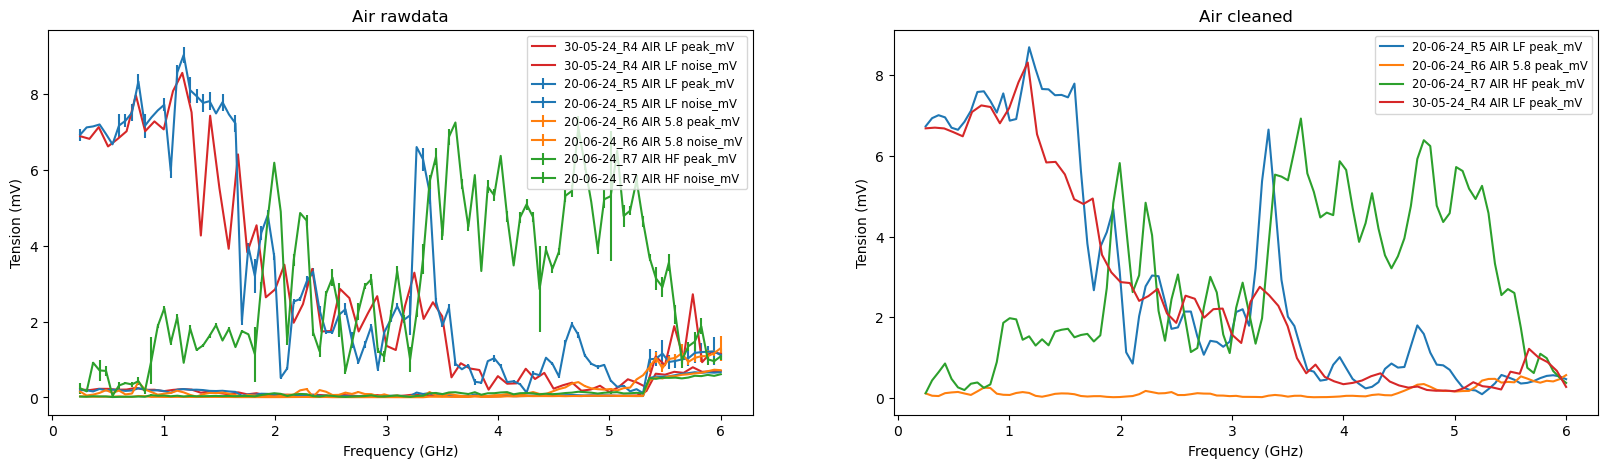

In [3]:
air_rawdata = df[df['sample'] == 'AIR']
air_data = denoisePipe(air_rawdata)
air_data = savgovFilterPipe(air_data, 5, 2)

fig, axs = plt.subplots(1,2, figsize = (20,5))
axs = axs.flatten()

air_rawdata.groupby(['id', 'antenna']).apply(plotThis, axs[0])
air_data.groupby(['id', 'antenna']).apply(plotThis, axs[1])

axs[0].set_title('Air rawdata')
axs[1].set_title('Air cleaned')

for ax in axs:
    ax.set(xlabel='Frequency (GHz)',
           ylabel = 'Tension (mV)')
    ax.legend(fontsize = 'small')
    
# drop 5.8 because its very bad
air_data = air_data.query('antenna != 5.8')

A questo punto conviene fittare i dati in gruppi dividendo per l'antenna usata:

fitting group HF with 1 samples
minimization status:  Optimization terminated successfully.
nomal minimization weights:  [1.]
correlation with the data:  [1. 1.]
fitting group LF with 2 samples
minimization status:  Optimization terminated successfully.
nomal minimization weights:  [0.477 0.523]
correlation with the data:  [0.985 0.985 1.   ]


c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\alber\a

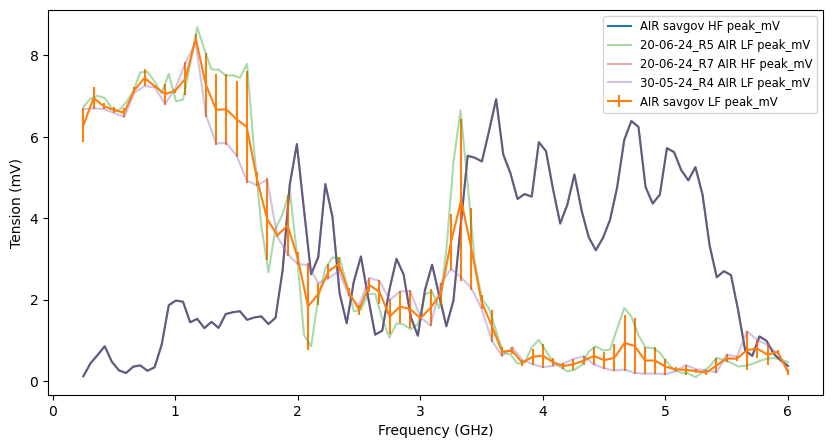

In [4]:
processed_data = processPipe(air_data, 'antenna', 'savgov')
    
# plot the data
fig, ax = plt.subplots()
processed_data.groupby('antenna').apply(plotThis, ax)
air_data.groupby('id').apply(plotThis, ax, alpha = 0.4)
formatPlot(ax)

# Analisi dell'effetto della scatola 
Abbiamo analizzato lo spettro del segnale quando sono presenti solo le due antenne, adesso vogliamo confrontarlo con lo spettro che ha il segnale quando aggiungiamo 
la nostra scatola in modo da vedere se ci sono delle differenze o delle risonanze a certe frequenze.

fitting group HF with 1 samples
minimization status:  Optimization terminated successfully.
nomal minimization weights:  [1.]
correlation with the data:  [1. 1.]
fitting group LF with 1 samples
minimization status:  Optimization terminated successfully.
nomal minimization weights:  [1.]
correlation with the data:  [1. 1.]


c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\alber\a

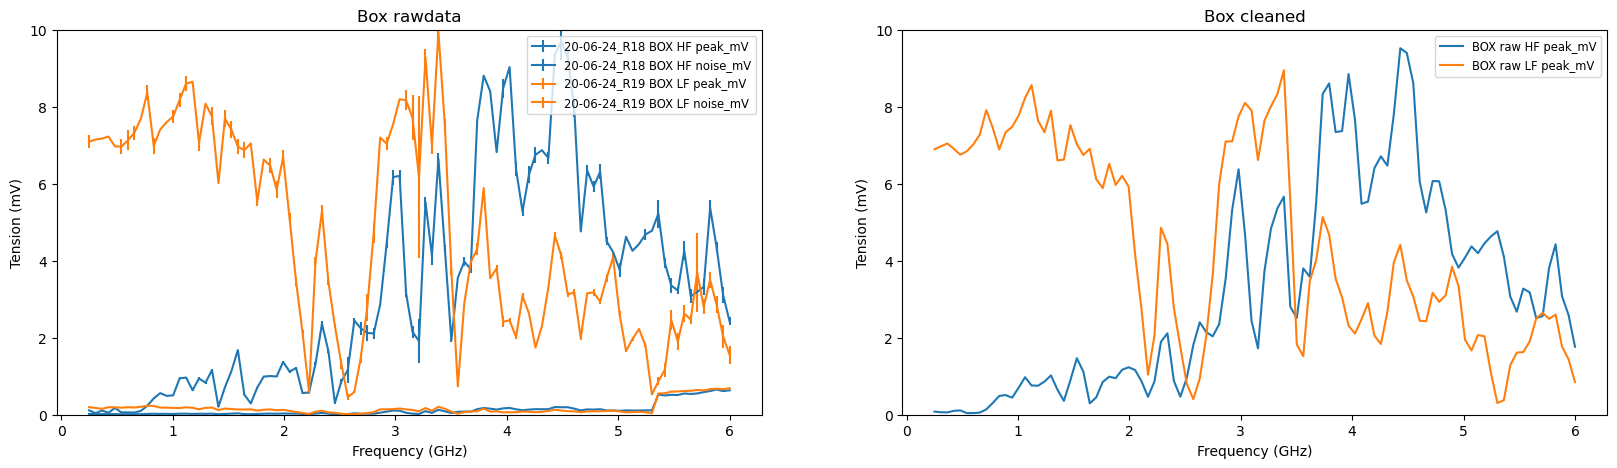

In [5]:
box_rawdata = df[df['sample'] == 'BOX']
box_data = denoisePipe(box_rawdata)
#box_data = FFTFilterPipe(box_data, 0.2, 5)
box_data = savgovFilterPipe(box_data, 4, 2)
box_data = processPipe(box_data)

# append it to the processed data
processed_data = pd.concat([processed_data, box_data])


# plot stuff
fig, axs = plt.subplots(1,2, figsize = (20,5))
axs = axs.flatten()

box_rawdata.groupby(['id', 'antenna']).apply(plotThis, axs[0])
box_data.groupby(['antenna']).apply(plotThis, axs[1])

axs[0].set_title('Box rawdata')
axs[1].set_title('Box cleaned')
for ax in axs:
    ax.set_ylim(0,10)
formatPlot(axs)


Una cosa interessante da notare è che, sebbene disponiamo di sole due misure, potrebbe essere possibile ricostruire meglio il segnale vero perché i due segnali si assomigliano! Basterebbe solo riscalarli in modo opportuno, magari con un polinomio. Questa misura è buona perché nelle altre è più difficile trovare le somiglianze tra HF e LF...
 
Dal momento che abbiamo solo una misura per antenna non serve approfondire l'analisi ulteriormente perché non è possibile fare ulteriore statistica con i dati a disposizione. Adesso la domanda è: che cosa cambia inserendo la scatola tra le due antenne?

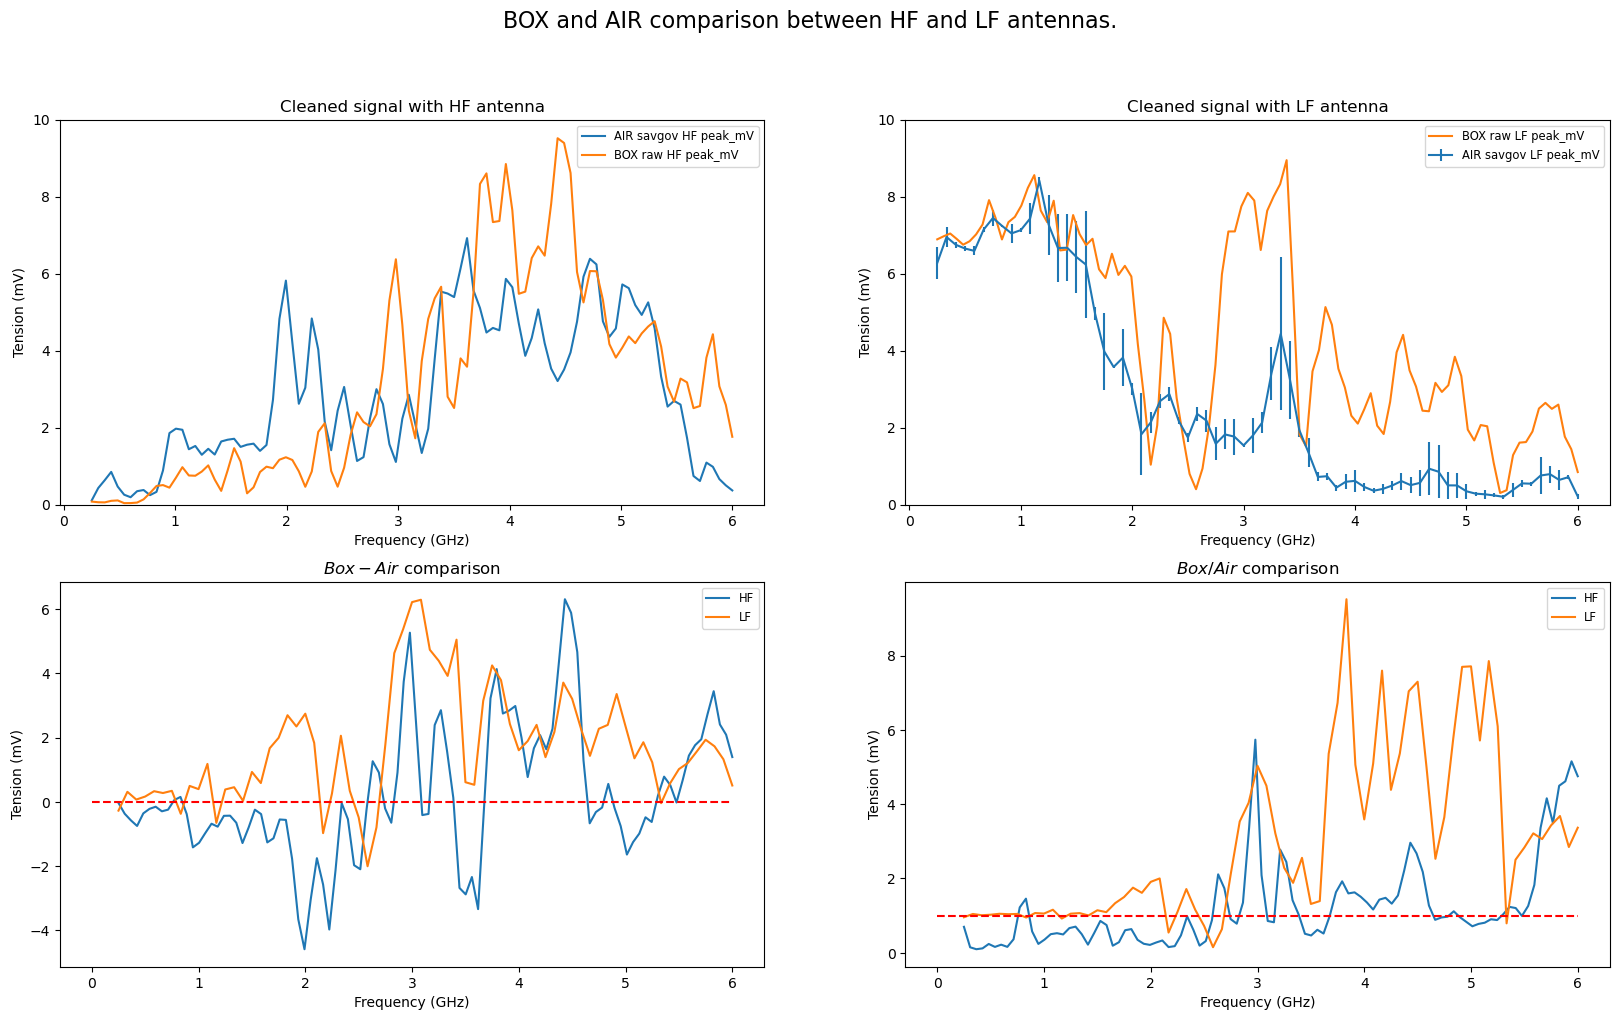

In [6]:
fig, axs = plt.subplots(2,2, figsize = (20,11))
axs = axs.flatten()
processed_data[processed_data['antenna'] == 'HF'].groupby(['sample']).apply(plotThis, axs[0])
processed_data[processed_data['antenna'] == 'LF'].groupby(['sample']).apply(plotThis, axs[1])

for antenna_name, antenna_group in processed_data.groupby('antenna'):
   antenna_group = resamplePipe(antenna_group, by='sample')
   diff = antenna_group[antenna_group['sample'] == 'BOX'][k.pek] - antenna_group[antenna_group['sample'] == 'AIR'][k.pek]
   div = antenna_group[antenna_group['sample'] == 'BOX'][k.pek] / antenna_group[antenna_group['sample'] == 'AIR'][k.pek]
   axs[2].plot(getResampledFreq(antenna_group, 'sample'), diff, label = antenna_name)
   axs[3].plot(getResampledFreq(antenna_group, 'sample'), div, label = antenna_name)

# some more info about the plots
fig.suptitle('BOX and AIR comparison between HF and LF antennas.', fontsize = 16)
axs[0].set(title = r'Cleaned signal with HF antenna')
axs[1].set(title = r'Cleaned signal with LF antenna')
axs[2].set(title = r'$Box - Air$ comparison')
axs[3].set(title = r'$Box / Air$ comparison',
          ylabel = 'BOX to AIR ratio')
axs[2].hlines(0, 0, 6, linestyles='dashed', color = 'red')
axs[3].hlines(1, 0, 6, linestyles='dashed', color = 'red')
for ax in axs[:2]:
    ax.set_ylim(0,10)
formatPlot(axs)

Amche qui si può notare come il segnale ad alta e bassa frequenza sia coerente. Potrebbe essere usato per combinare e ricostruire ulteriormente i dati.

# Analisi del silcio
Arriviamo adesso a voler capire che effetto abbia l'aggiunta del silicio all'interno del contenitore.
Abbiamo preso delle misure con il silicio semipieno ed altre con il silicio pieno. Di seguito quelle con il silicio semipieno saranno tratteggiate per distinguerle dalle altre.
Sembrerebbe che lo spettro si sposti un po'tra silicio pieno e semipieno.

fitting group HF with 1 samples
minimization status:  Optimization terminated successfully.
nomal minimization weights:  [1.]
correlation with the data:  [1. 1.]
fitting group LF with 1 samples
minimization status:  Optimization terminated successfully.
nomal minimization weights:  [1.]
correlation with the data:  [1. 1.]


c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alber\anaconda3\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\alber\a

Text(0.3, 1, 'dashed lines represent half full silica samples')

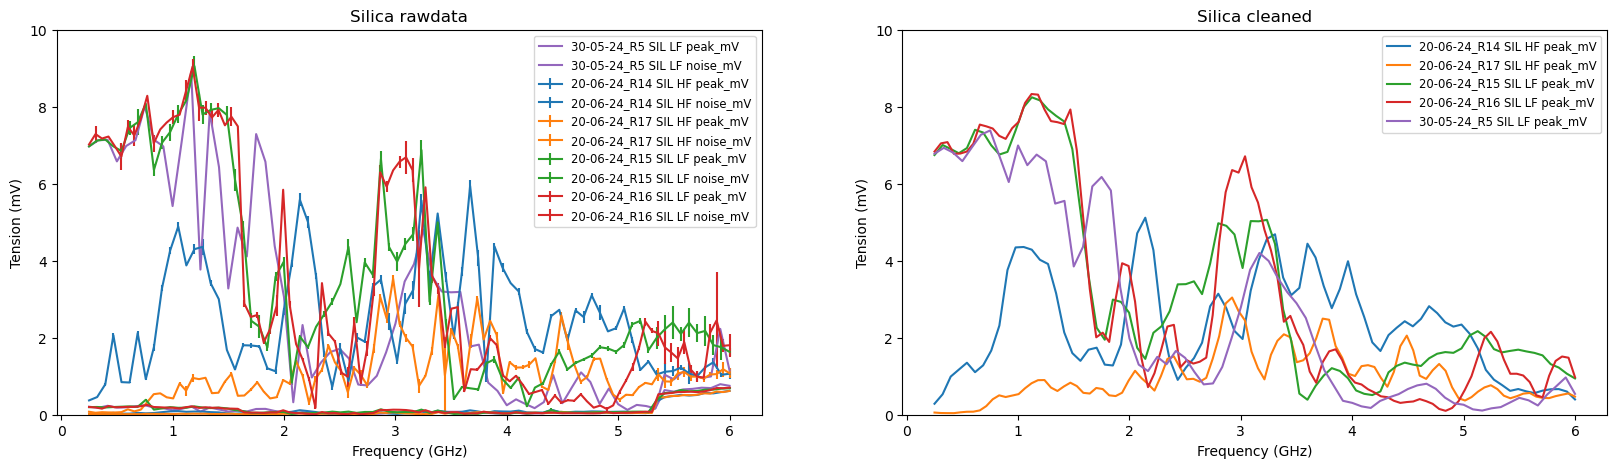

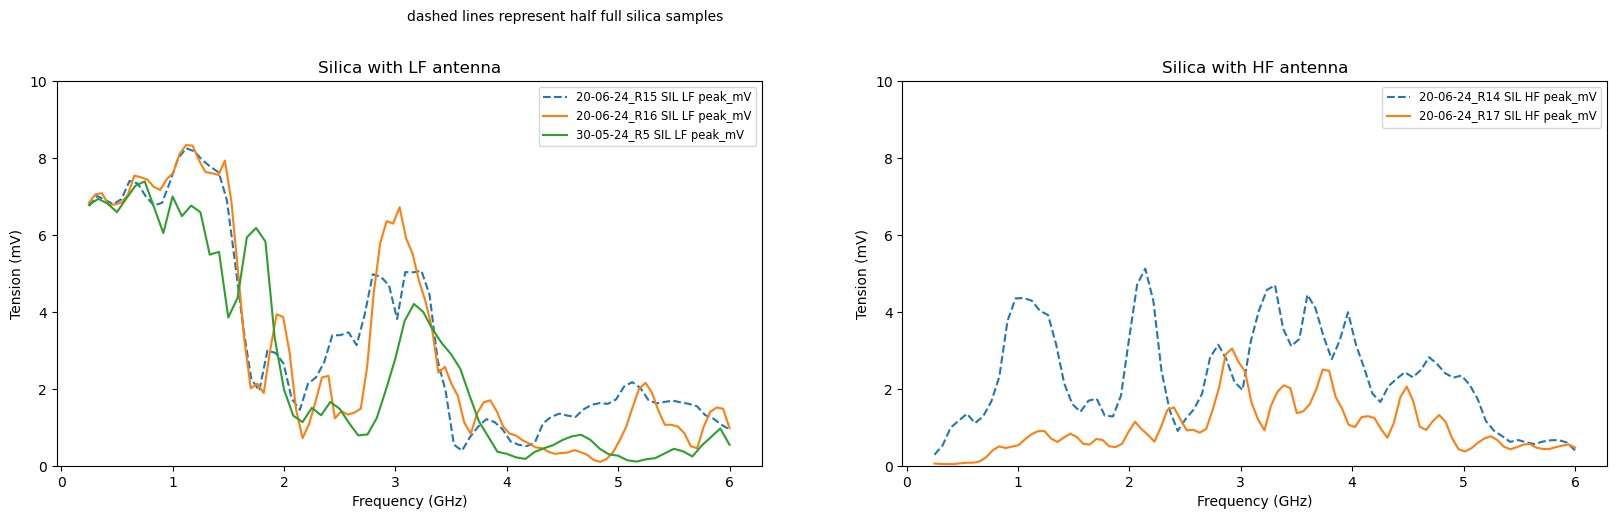

In [7]:
# prepare and clean the data
sil_rawdata = df[df['sample'] == 'SIL']
sil_data = denoisePipe(sil_rawdata)
sil_data = savgovFilterPipe(sil_data, 6, 3)
# process and append ONLY THE HALF FULL to the processed data
# this is somewhat arbitrary but we need to go on
# as simply as possible for the moment
sil_to_keep = ['20-06-24_R14', '20-06-24_R15']
tmp = processPipe(sil_data[sil_data['id'].isin(sil_to_keep)])
processed_data = pd.concat([processed_data, tmp])

# ... PLOTTING ...
fig, axs = plt.subplots(1,2, figsize = (20,5))
axs = axs.flatten()
sil_rawdata.groupby(['antenna', 'id']).apply(plotThis, axs[0])
sil_data.groupby(['antenna', 'id']).apply(plotThis, axs[1])
axs[0].set_title('Silica rawdata')
axs[1].set_title('Silica cleaned')
for ax in axs:
    ax.set_ylim(0,10)
formatPlot(axs)

# Divide the data into HF and LF
fig, axs = plt.subplots(1,2, figsize = (20,5))
axs = axs.flatten()
sil_data[sil_data['antenna'] == 'LF'].groupby('id').apply(plotThis, axs[0])
sil_data[sil_data['antenna'] == 'HF'].groupby('id').apply(plotThis, axs[1])
axs[0].get_lines()[0].set_linestyle('dashed')
axs[1].get_lines()[0].set_linestyle('dashed')
axs[0].set_title('Silica with LF antenna')
axs[1].set_title('Silica with HF antenna')
for ax in axs:
    ax.set_ylim(0,10)
formatPlot(axs)
fig.text(0.3,1, 'dashed lines represent half full silica samples')

Come prima vediamo che cosa è cambiato rispetto allo step precedente in cui avevamo solo la scatola.

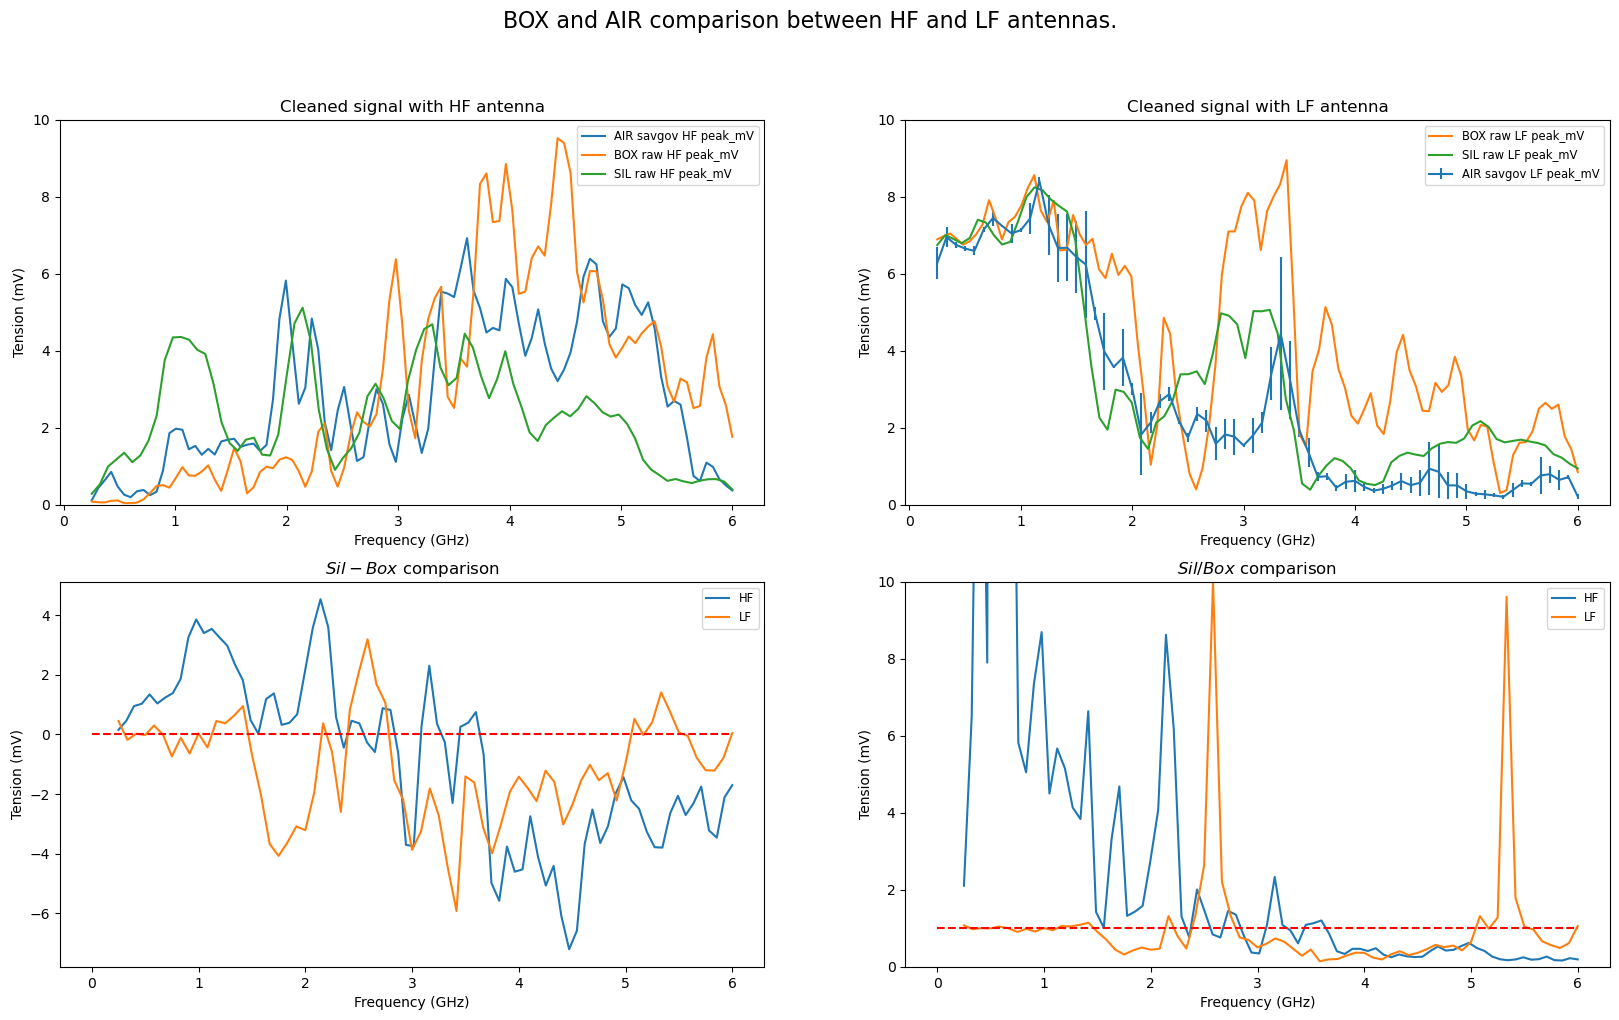

In [8]:
fig, axs = plt.subplots(2,2, figsize = (20,11))
axs = axs.flatten()
processed_data[processed_data['antenna'] == 'HF'].groupby(['sample']).apply(plotThis, axs[0])
processed_data[processed_data['antenna'] == 'LF'].groupby(['sample']).apply(plotThis, axs[1])

for antenna_name, antenna_group in processed_data.groupby('antenna'):
   antenna_group = resamplePipe(antenna_group, by='sample')
   diff = antenna_group[antenna_group['sample'] == 'SIL'][k.pek] - antenna_group[antenna_group['sample'] == 'BOX'][k.pek]
   div = antenna_group[antenna_group['sample'] == 'SIL'][k.pek] / antenna_group[antenna_group['sample'] == 'BOX'][k.pek]
   axs[2].plot(getResampledFreq(antenna_group, 'sample'), diff, label = antenna_name)
   axs[3].plot(getResampledFreq(antenna_group, 'sample'), div, label = antenna_name)

# some more info about the plots
fig.suptitle('BOX and AIR comparison between HF and LF antennas.', fontsize = 16)
axs[0].set(title = r'Cleaned signal with HF antenna')
axs[1].set(title = r'Cleaned signal with LF antenna')
axs[2].set(title = r'$Sil - Box$ comparison')
axs[3].set(title = r'$Sil / Box$ comparison',
          ylabel = 'SIL to BOX ratio')
axs[2].hlines(0, 0, 6, linestyles='dashed', color = 'red')
axs[3].hlines(1, 0, 6, linestyles='dashed', color = 'red')
for ax in axs[:2]:
    ax.set_ylim(0,10)
axs[3].set_ylim(0,10)
formatPlot(axs)

# Analisi del cristallo fotonico
Questa è la sezione dell'analisi di cui disponiamo più misure. I dati sono stati raccolti in batches relative alla stessa configurazione del cristallo in questo modo:

```python
batch1 = ['30-05-24_R0', '30-05-24_R1', '30-05-24_R2', '30-05-24_R6']
batch2 = ['20-06-24_R1', '20-06-24_R2', '20-06-24_R3']
batch3 = ['20-06-24_R8', '20-06-24_R9', '20-06-24_R10', '20-06-24_R11']
```

- '20-06-24_R4' è relativa al primo batch con inclinazione di 8.25 deg.
- '20-06-24_R12' è l'evoluzione nel tempo del segnale nell'arco di 6 min.
- '20-06-24_R13' inclinato di 5 deg.

I dati del batch uno sono praticamente inutilizzabili, non assomigliano per nulla agli altri dati e per tanto verranno scartati.

PCR samples list
 ['20-06-24_R1' '20-06-24_R10' '20-06-24_R11' '20-06-24_R12' '20-06-24_R13'
 '20-06-24_R2' '20-06-24_R3' '20-06-24_R4' '20-06-24_R8' '20-06-24_R9'
 '30-05-24_R0' '30-05-24_R1' '30-05-24_R2' '30-05-24_R6']

processing batch:  ['20-06-24_R1', '20-06-24_R2', '20-06-24_R3']
fitting group LF with 3 samples
minimization status:  Optimization terminated successfully.
nomal minimization weights:  [0.328 0.338 0.335]
correlation with the data:  [0.992 0.994 0.995 1.   ]
fitting group LF with 3 samples
minimization status:  Optimization terminated successfully.
nomal minimization weights:  [0.329 0.337 0.335]
correlation with the data:  [0.995 0.994 0.996 1.   ]
fitting group LF with 3 samples
minimization status:  Optimization terminated successfully.
nomal minimization weights:  [0.326 0.337 0.337]
correlation with the data:  [0.993 0.995 0.998 1.   ]

processing batch:  ['20-06-24_R8', '20-06-24_R9', '20-06-24_R10', '20-06-24_R11']
fitting group HF with 4 samples
minimization

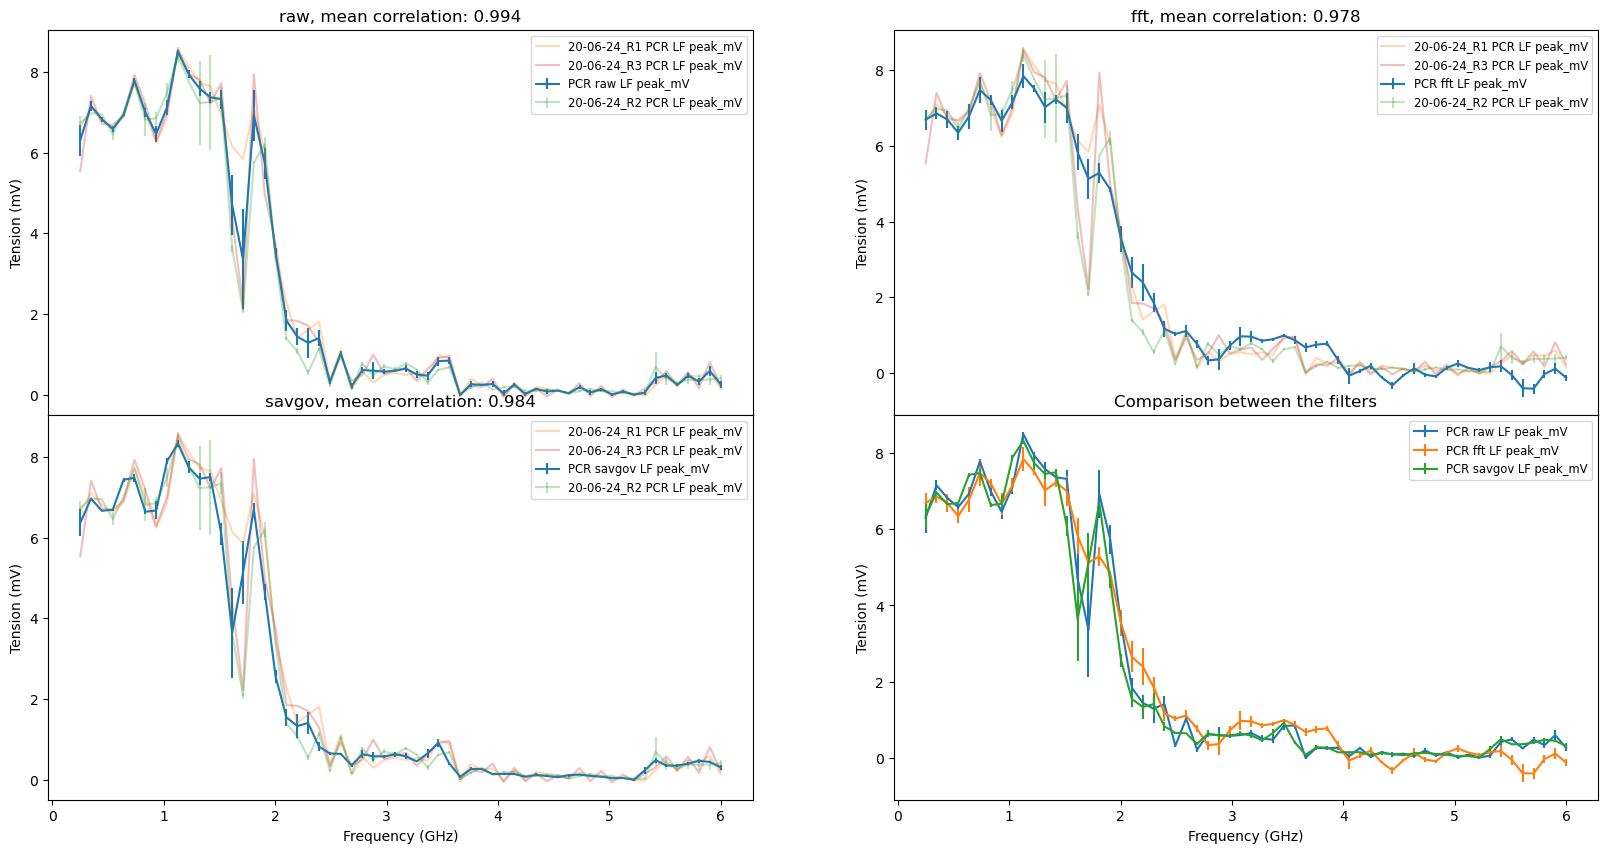

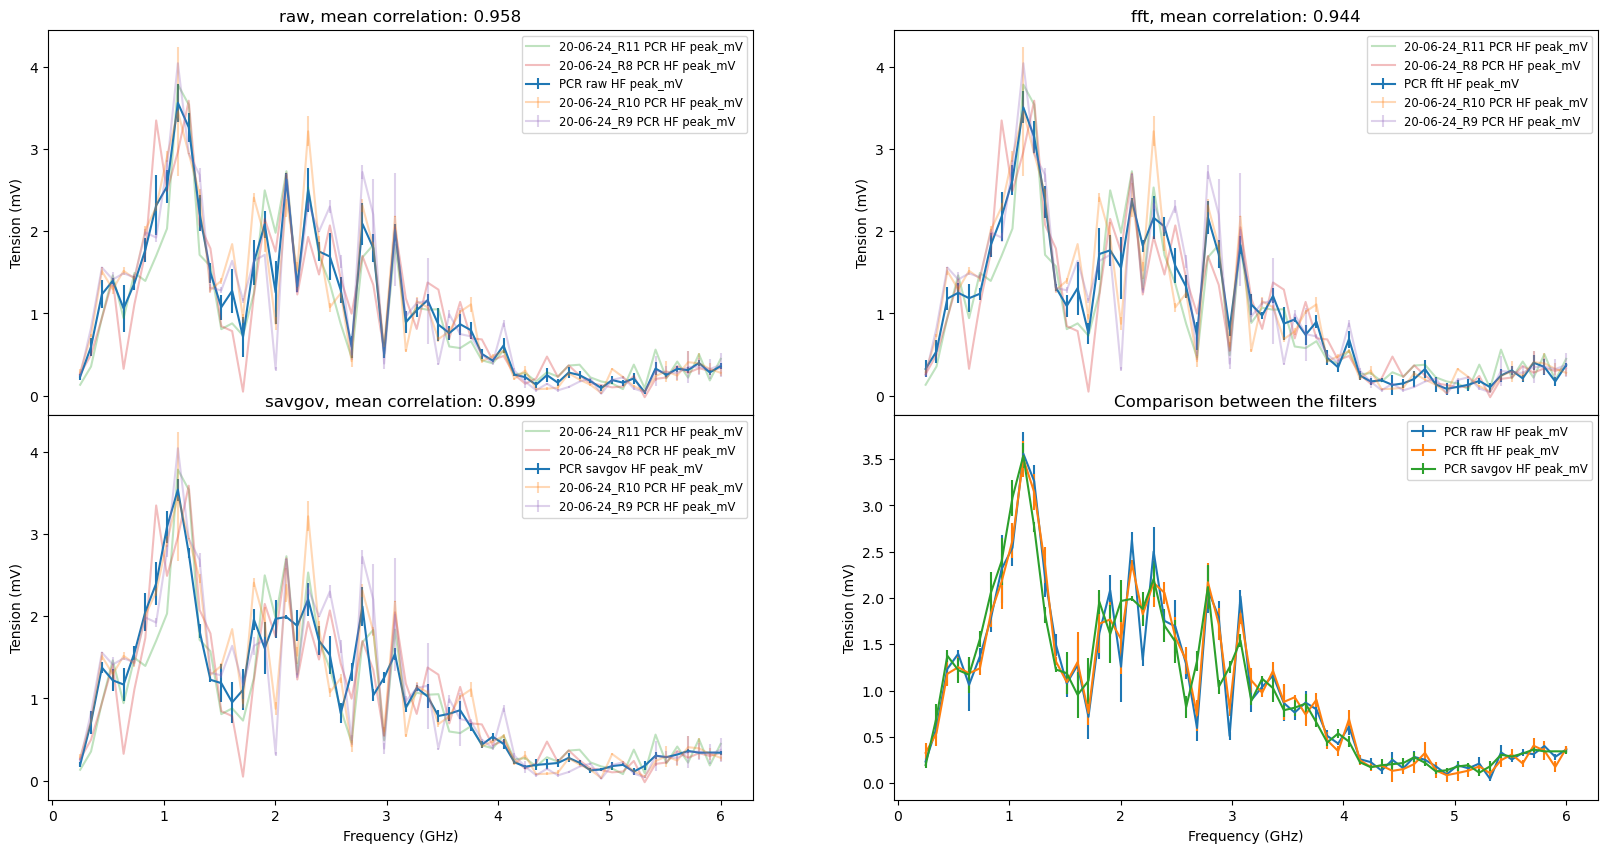

In [9]:
def PCR_PROCESSING():
    global processed_data

    # prepare and clean the data
    pcr_rawdata = df[df['sample'] == 'PCR']
    pcr_data = denoisePipe(pcr_rawdata)
    print('PCR samples list\n', pcr_data['id'].unique())

    batch1 = ['30-05-24_R0', '30-05-24_R1', '30-05-24_R2', '30-05-24_R6']
    batch2 = ['20-06-24_R1', '20-06-24_R2', '20-06-24_R3']
    batch3 = ['20-06-24_R8', '20-06-24_R9', '20-06-24_R10', '20-06-24_R11']

    for batch in [batch2, batch3]:
        print('\nprocessing batch: ', batch)
        # process the data
        data_batch = pcr_data[pcr_data['id'].isin(batch)]
        # resample here because it is a destructive operation
        # and should only be done in a batch at the last moment
        data_batch = resamplePipe(data_batch)
        processed = {}
        
        tmp = processPipe(data_batch, by='antenna', proc_name ='raw')
        processed['raw'] = tmp
        
        tmp = FFTFilterPipe(data_batch, 0.3, 5)
        tmp = processPipe(tmp, by='antenna', proc_name ='fft')
        processed['fft'] = tmp
        
        tmp = savgovFilterPipe(data_batch, 4, 2)
        tmp = processPipe(tmp, by='antenna', proc_name ='savgov')
        processed['savgov'] = tmp
        
        # save the data 
        processed_data = pd.concat([processed_data, *processed.values()])

        # and plot it
        fig, axs = plt.subplots(2,2, figsize=(20,10), sharex=True)
        fig.subplots_adjust(hspace=0)
        axs = axs.flatten()

        for i, name in enumerate(['raw', 'fft', 'savgov']):  
            corr = corrModelToData(data_batch, processed[name])[:-1].mean()
            axs[i].set(title = f'{name}, mean correlation: {corr:.3f}')
            processed[name].groupby(['antenna']).apply(plotThis, axs[i])
            data_batch.groupby('id').apply(plotThis, axs[i], alpha = 0.3)

        axs[3].set(title='Comparison between the filters')
        for item in processed.values():
            item.groupby(['antenna']).apply(plotThis, axs[3])
        
        formatPlot(axs)


PCR_PROCESSING()

Index(['sample', 'process', 'antenna', 'frequency_GHz', 'peak_mV',
       'sigma_peak_mV'],
      dtype='object')
['AIR' 'BOX' 'SIL' 'PCR']


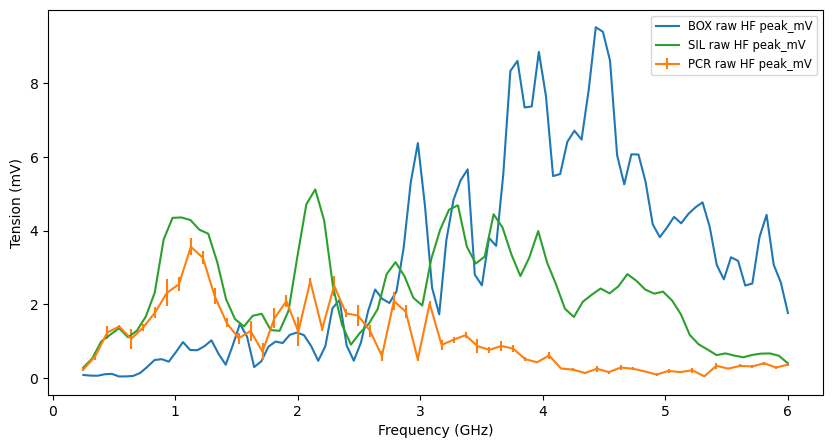

In [10]:
fig, ax = plt.subplots()
print(processed_data.columns)
print(processed_data['sample'].unique())

query = "   antenna == 'HF' and (process == 'raw')\
            and (sample == 'SIL' | sample == 'PCR' | sample == 'BOX') "
processed_data.query(query).groupby(['sample', 'process', 'antenna']).apply(plotThis, ax)
formatPlot(ax)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(100, 6) (60, 6)
0     0.064651
1    -0.569751
2    -1.025261
3    -1.226349
4    -1.118594
5    -1.073551
6    -1.329119
7    -1.730166
8    -1.813097
9    -2.681821
10   -2.342273
11   -1.419677
12   -0.941044
13    0.262281
14   -0.486499
15   -0.377020
16   -0.705724
17   -0.797053
18   -0.253802
19   -1.448895
20   -1.261661
21   -0.344859
22   -0.570664
23   -1.226624
24    0.684090
25    1.407595
26    0.027426
27    1.648378
28    5.566666
29    1.894488
30    0.980872
31    3.398081
32    4.551311
33    2.304847
34    2.167906
35    3.525333
36    7.233198
37    7.333541
38    7.548086
39    7.086360
40    4.868894
41    6.582979
42    6.297997
43    8.868605
44    9.170844
45    6.091536
46    5.210858
47    5.969438
48    3.971513
49    3.982581
50    4.087271
51    4.272303
52    4.615253
53    3.570964
54    2.345967
55    3.197540
56    1.877531
57    3.552737
58    3.485475
59    1.875751
Name: peak_mV, dtype: float64


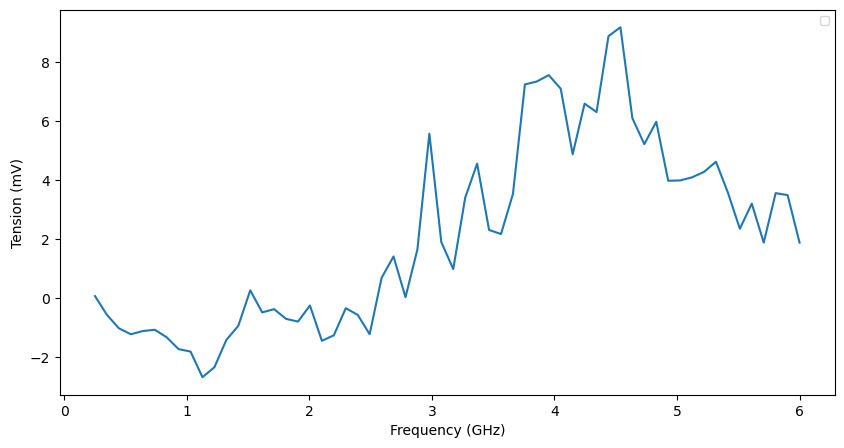

In [39]:
def test():

    query = "antenna == 'HF' and (process == 'fft')\
            and (sample == 'PCR') "
    pcr = processed_data.query(query)
    
    query = "antenna == 'HF' \
            and (sample == 'BOX') "
    box = processed_data.query(query)
    
    
    diff = scipy.signal.resample(box[k.pek], 60)  - pcr[k.pek]
    
    
    fig, ax = plt.subplots()
    #plotThis(pcr, ax)
    #plotThis(box, ax)
    ax.plot(pcr[k.freq], diff)
    formatPlot(ax)
    return
test()

# Analisi della dipendenza temporale del segnale
Adesso vogliamo concentrarci su quello che sembrerebbe essere un problema di riproducibilità dei dati: a tempi diversi si misurano diverse cose. Questo è ovviamente un problema, ma forse è possibile interpolare i dati per estrarre un segnale pulito.

I dati presi in funzione del tempo non sono inseriti all'interno dei *labeldata* ma sono stati lasciati nei *rawdata*. Importandoli e facendo un plot si analizza il segnale nel tempo:

Index(['Frequency (GHz)', 'Peak (mV)', 'Noise (mV)', 'Time (s)',
       'SigPeak (mV)', 'SigNoise (mV)'],
      dtype='object')


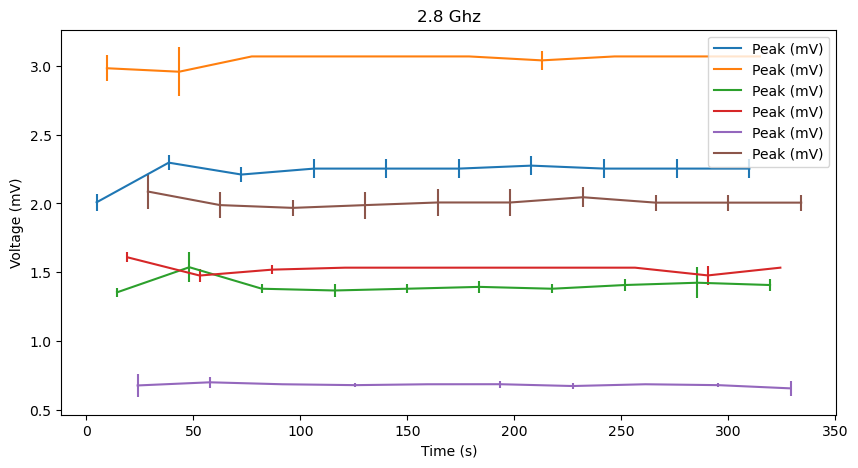

In [11]:
def TimeDependenceOfTheSignal():
    
    path = os.path.join(prj_path, 'rawdata', '20-06-24' ,'HF_LNA_PCR_R12.txt')
    data = pd.read_csv(path)
    
    print(data.columns.unique())
    
    fig, ax = plt.subplots()
    
    for name, group in data.groupby('Frequency (GHz)'):
        group.plot(x='Time (s)', y='Peak (mV)', yerr='SigPeak (mV)', 
                   title=' '.join([str(name), 'Ghz']), 
                   ylabel='Voltage (mV)', ax=ax)
    return

TimeDependenceOfTheSignal()

Da questa analisi preliminare il segnale sembrerebbe essere stabile... 
Abbiamo anche ripetuto una stessa misura due volte, vediamo se le due misure sono coerenti. R8 R9 R10 sono tutte la stessa misura, ma R9 ed R10 hanno 60 punti, mentre R8 ne ha di più. Confrontando R9 ed R10 è possibile vedere se la misura è riproducibile.

             id  frequency_GHz   peak_mV  sigma_peak_mV  noise_mV  \
55  20-06-24_R9        5.61017  0.768808       0.087299  0.490667   
56  20-06-24_R9        5.70763  0.863090       0.194798  0.514333   
57  20-06-24_R9        5.80508  0.917316       0.098674  0.562667   
58  20-06-24_R9        5.90254  0.917696       0.124338  0.593667   
59  20-06-24_R9        6.00000  0.987089       0.146268  0.611667   

    sigma_noise_mV sample antenna  
55        0.007763    PCR      HF  
56        0.006408    PCR      HF  
57        0.007005    PCR      HF  
58        0.006022    PCR      HF  
59        0.004676    PCR      HF  
['20-06-24_R10' '20-06-24_R9']


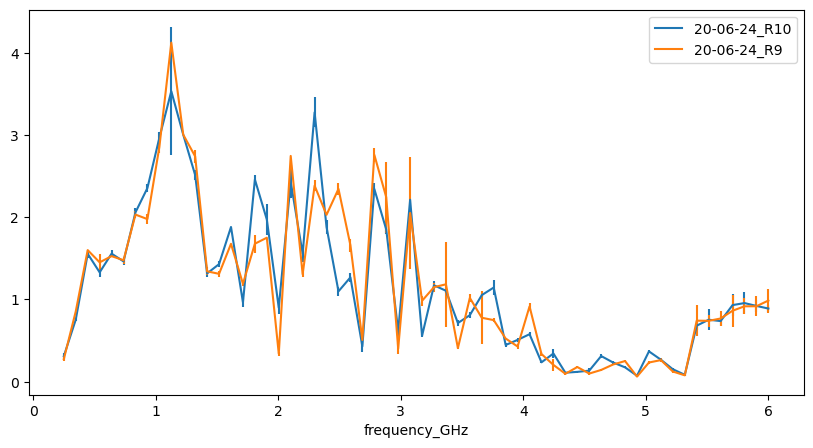

In [12]:
def ReproducibilityOfTheMeasures():
    data = df[df['id'].isin(['20-06-24_R9','20-06-24_R10'])]
    print(data.tail())
    print(data['id'].unique())
    
    fig, ax = plt.subplots()
    
    for name, group in data.groupby('id'):
        
        group.plot(x=k.freq, y=k.pek, yerr=k.sig_pek,
                   ax=ax, label=name)
    

    return
ReproducibilityOfTheMeasures()

Si vede dal grafico che i due segnali non sono compatibili in alcuni punti. Questo potrebbe essere dovuto al fatto che l'incertezza statistica sui punti è calcolata su periodi molto brevi (circa un secondo), mentre le variazioni del segnale sono per tempi lunghi. Verrebbe anche da dire che i risultati di questo grafico sono incompatibili con l'analisi del segnale nel tempo fatta nella sezione prima in quanto le oscillazioni tra due e tre gigahertz qui sono molto maggiori di quelle osservate in tre minuti. Serviranno altri modi per rimuovere il rumore dai dati. Potrebbe anche essere che quello che abbiamo osservato fosse rumore ambientale, non è da escludere.

## Ricostruzione del segnale sulle misure 8-9-10
Adesso mettiamo insieme queste tre misure per ricostruire il segnale al meglio possibile.

Il sendo di quello che verrà fatto adesso è fare un elaborazione del segnale usando la sua trasformata di Fourier, applicando due filtri:
- ampiezza: teniamo solo le frequenze che contribuiscono in maniera cospicua al segnale
- frequenza: togliamo le alte frequenze che potrebbero essere associate al rumore

La scelta di quanto filtro applicare è arbitraria e il rischio è rimuovere anche la parte di segnale che ci interessa... procediamo quindi per tentativi e vediamo se quello che otteniamo ha senso.

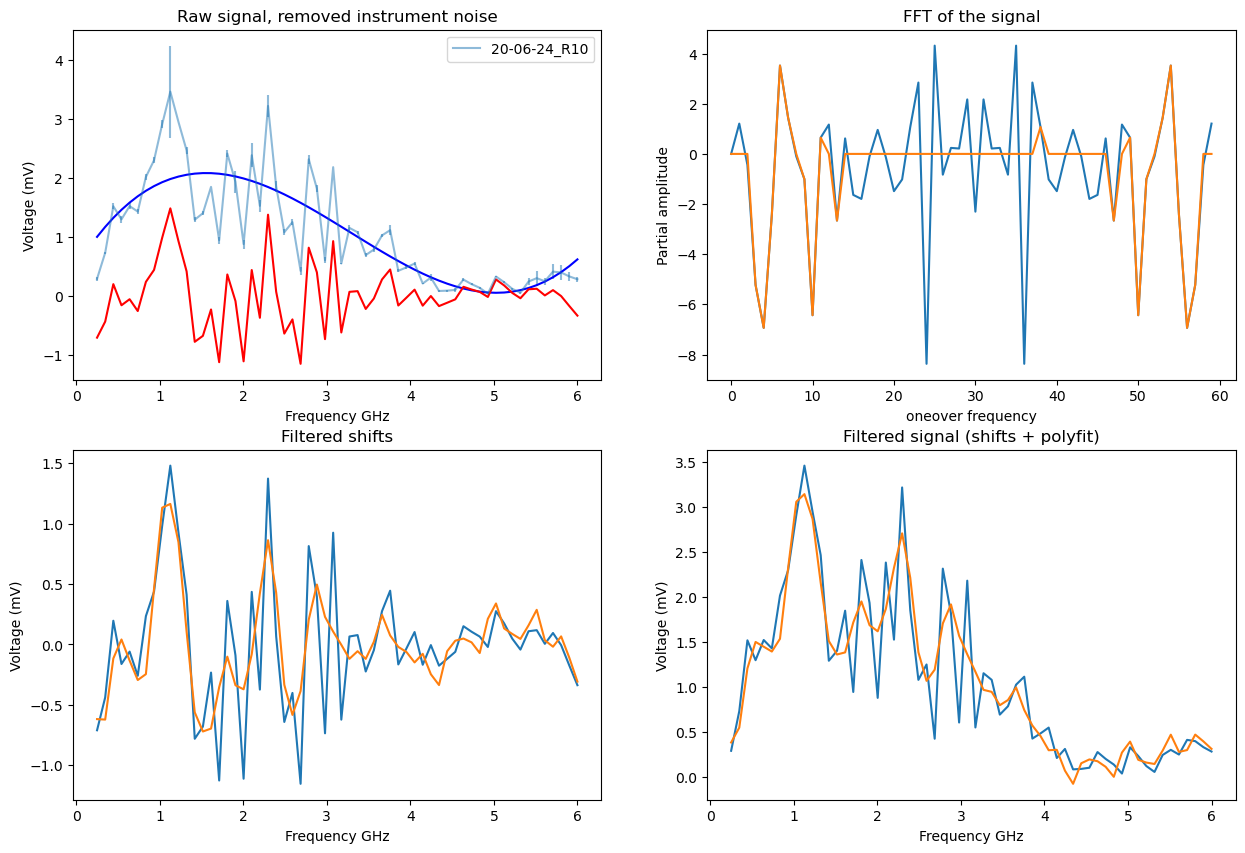

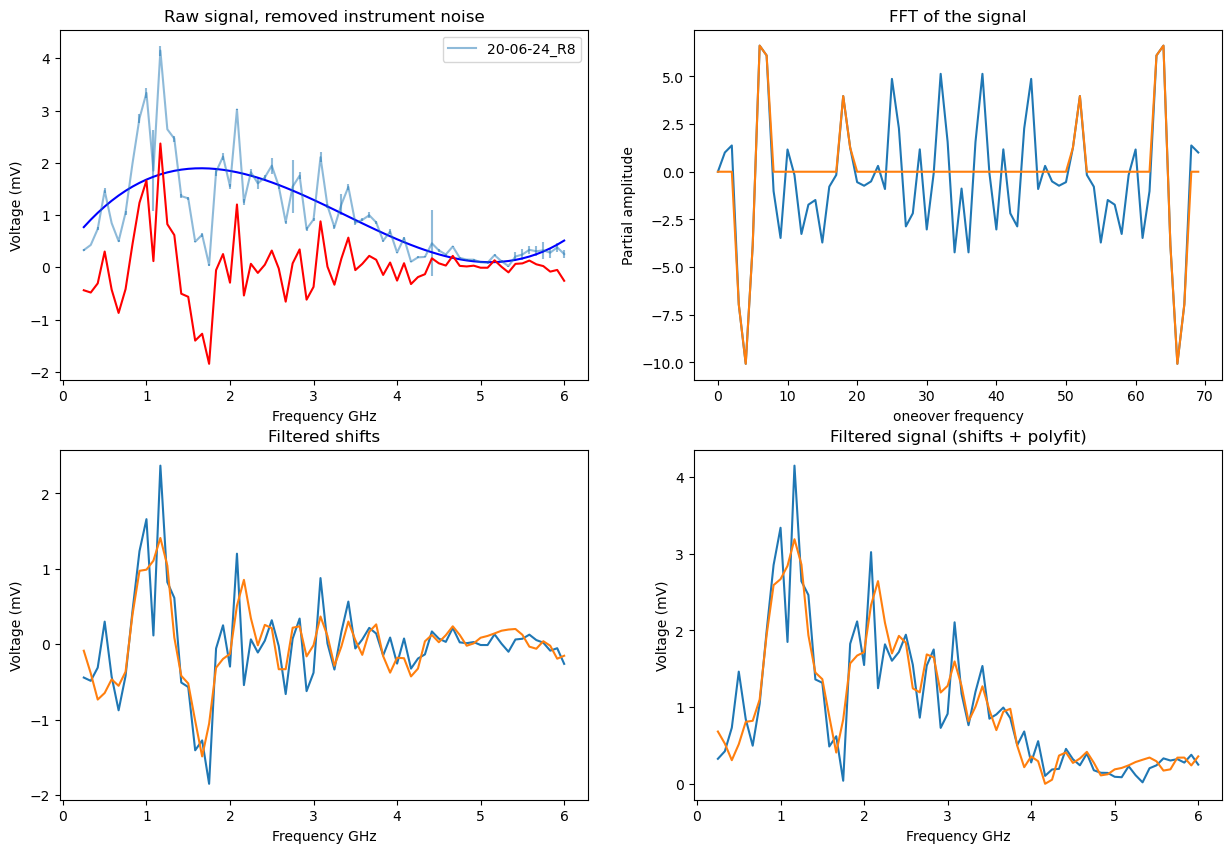

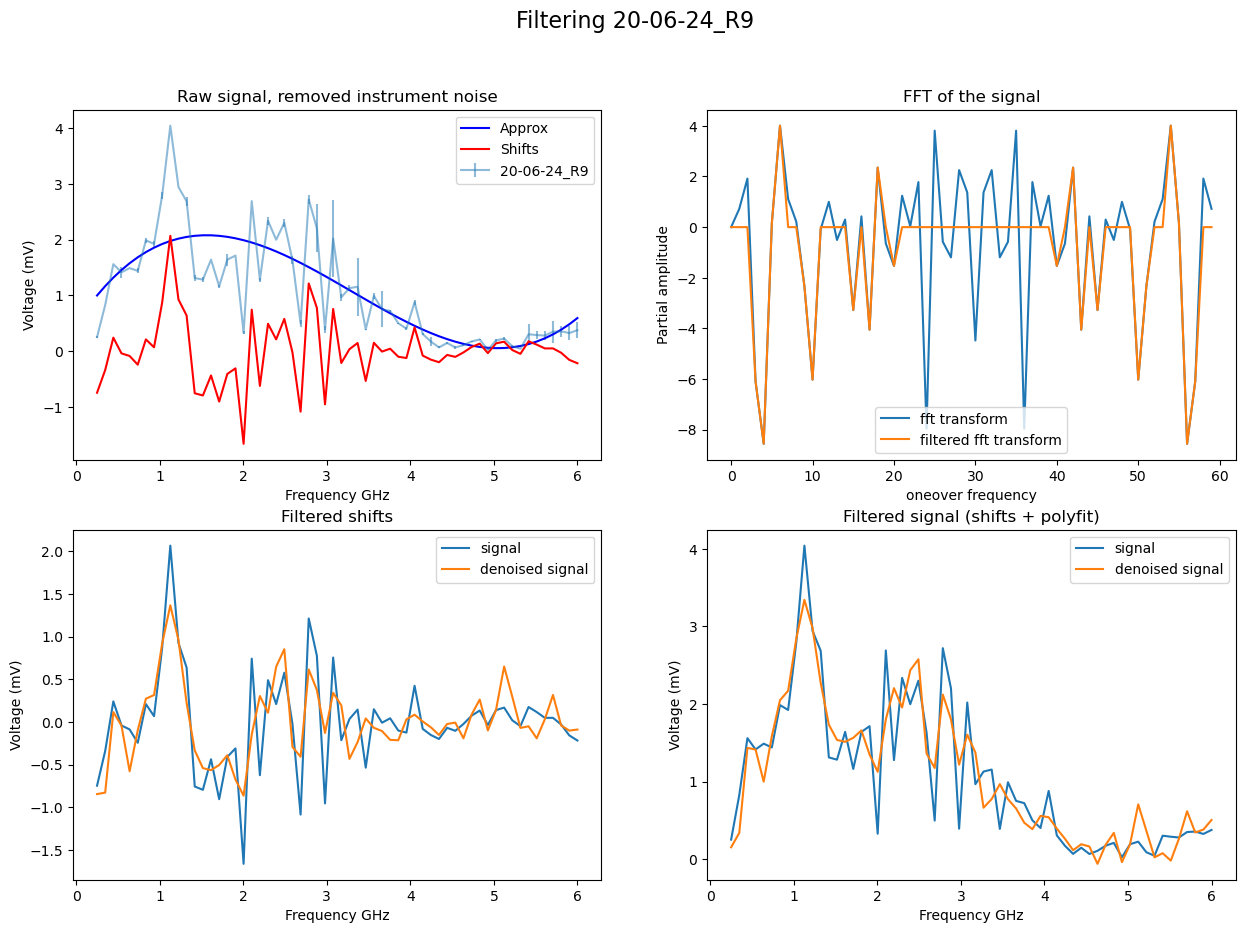

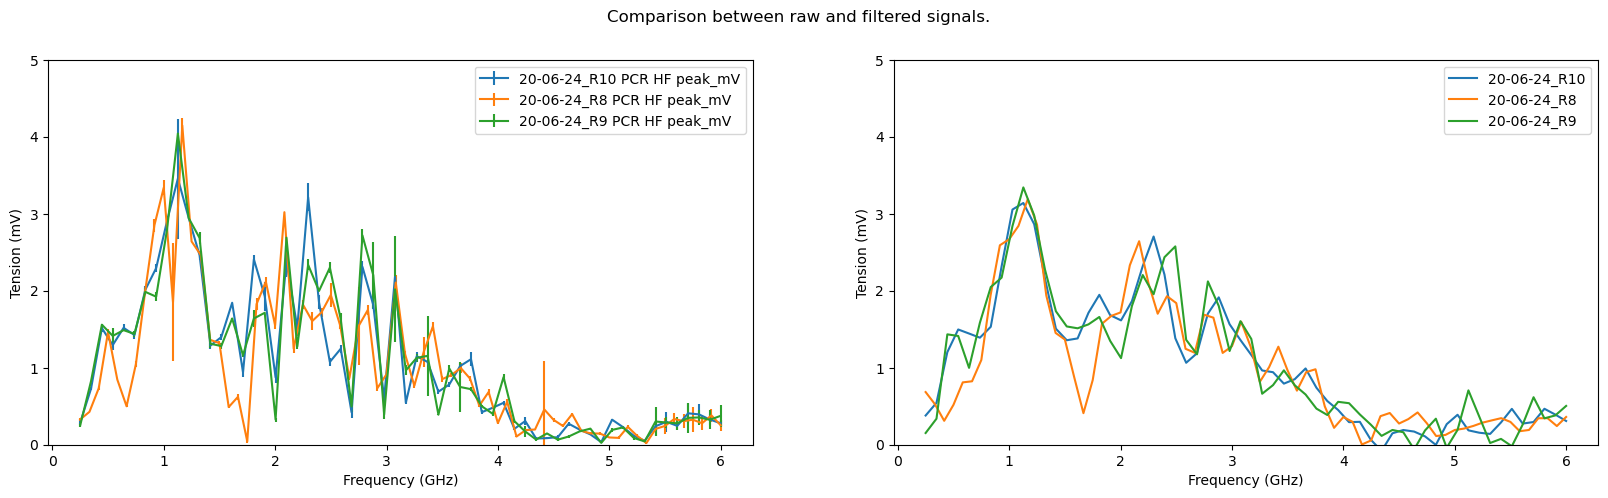

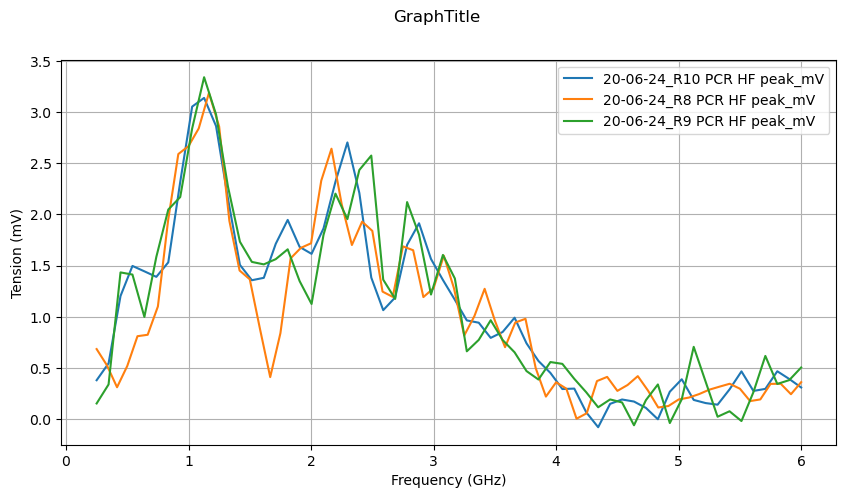

In [13]:
data = df[df['id'].isin(['20-06-24_R8', '20-06-24_R9','20-06-24_R10'])]
data = denoisePipe(data)
fft_denoise = FFTFilterPipe(data, 0.4, 8, plotFFT=True)
plotByID(fft_denoise)

Il problema adesso è sempre quello, combinare questi segnali...
Ho provato a dare un occhiata a come funzionano i filtri, ma non sembra quello di cui ho bisogno. Il modo più semplice per andare avanti e trovare un modo per ricostruire il segnale a partire da quelli che ho già vedendo la loro correlazione. Vediamo quindi se i segnali sono correlati o meno.

[[1.    0.852 0.947]
 [0.852 1.    0.849]
 [0.947 0.849 1.   ]]


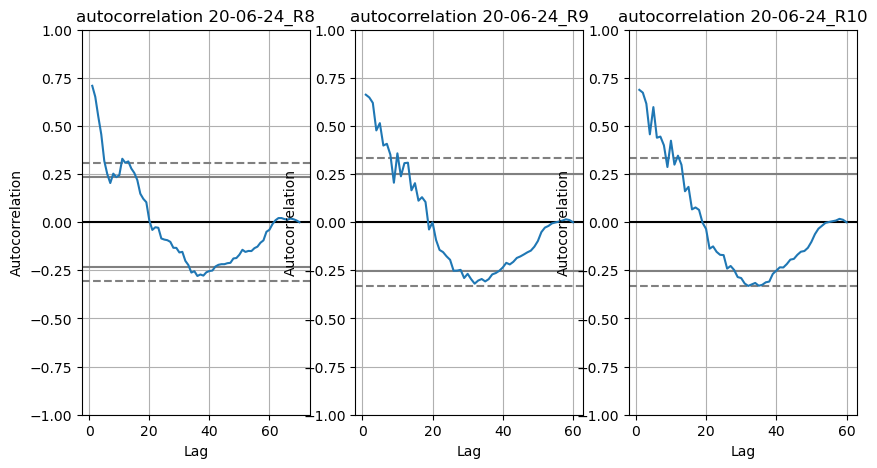

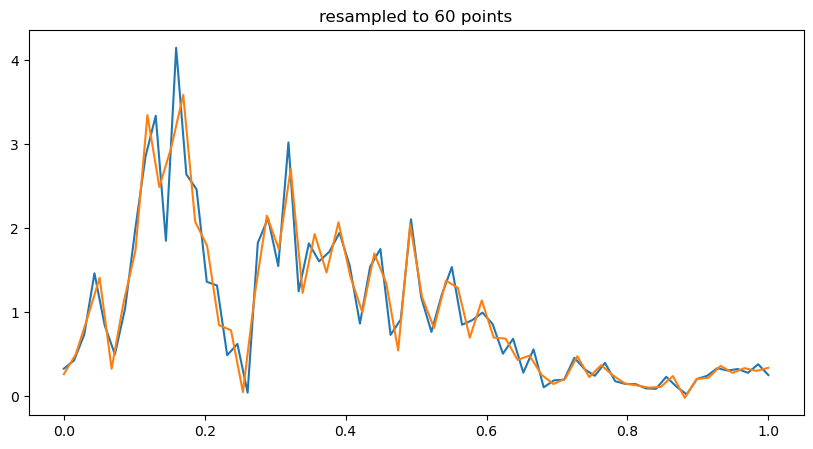

In [14]:
def CorrelationAnalysis():
    ids = ['20-06-24_R8', '20-06-24_R9','20-06-24_R10']
    data = df[df['id'].isin(ids)]
    
    # denoise data
    data = data.apply(denoise, axis=1)
    fig, axes = plt.subplots(1,3)
    
    for id, ax in zip(ids, axes.flatten()):  
        pd.plotting.autocorrelation_plot(data[data['id'] == id][k.pek], ax=ax)
        ax.set_title('autocorrelation %s'%id)
        ax.set_ylim(-1,1)


    # get the correlation between different columns
    series = {}
    for name, group in data.groupby('id'):
        series[name] = group[k.pek].values
    
    # resample the series with 70 elements to 60
    plt.subplots()
    plt.plot(np.linspace(0,1,70) , series[ids[0]])
    series[ids[0]] = scipy.signal.resample(series[ids[0]], 60, )
    plt.plot(np.linspace(0,1,60) , series[ids[0]])
    plt.title('resampled to 60 points')
    
    # print(series)
    print(np.corrcoef([i for i in series.values()]))

    return

CorrelationAnalysis()

Adesso che abbiamo delle idee più chiare sulla correlazione dei dati sarebbe bello unire tutti i segnali in modo da averne uno solo che meglio li rappresenti.
Possiamo fare ciò in questo modo: dati $x_1[n], \, $x_2[n]$, \, $x_3[n]$ le serie in input possiamo generare la loro unione $y[n]$ nel seguente modo:

$$ y[i] = \sum_{k = 1,2,3} a_k x_k[i]$$

tale che $\sum_k a_k = 1$, in questo modo la funzione rimane normalizzata. Ho solo due parametri liberi $a_1$ e $a_2$ e voglio massimizzare la somma delle correlazioni:

$$E = \sum_{ij} C_{ij}$$

nomal minimization weights:  [0.303 0.303 0.294]
correlation with the data:  [0.973 0.936 0.972 1.   ]
fft filtering minimization weights:  [0.304 0.299 0.296]
correlation with the data:  [0.976 0.956 0.977 1.   ]
 correlation between the two models:
 [[1.    0.963]
 [0.963 1.   ]]
cross correlation fft with the data:  [0.927 0.923 0.925 1.   ]
cross correlation normal with the fftdata:  [0.936 0.93  0.937 1.   ]


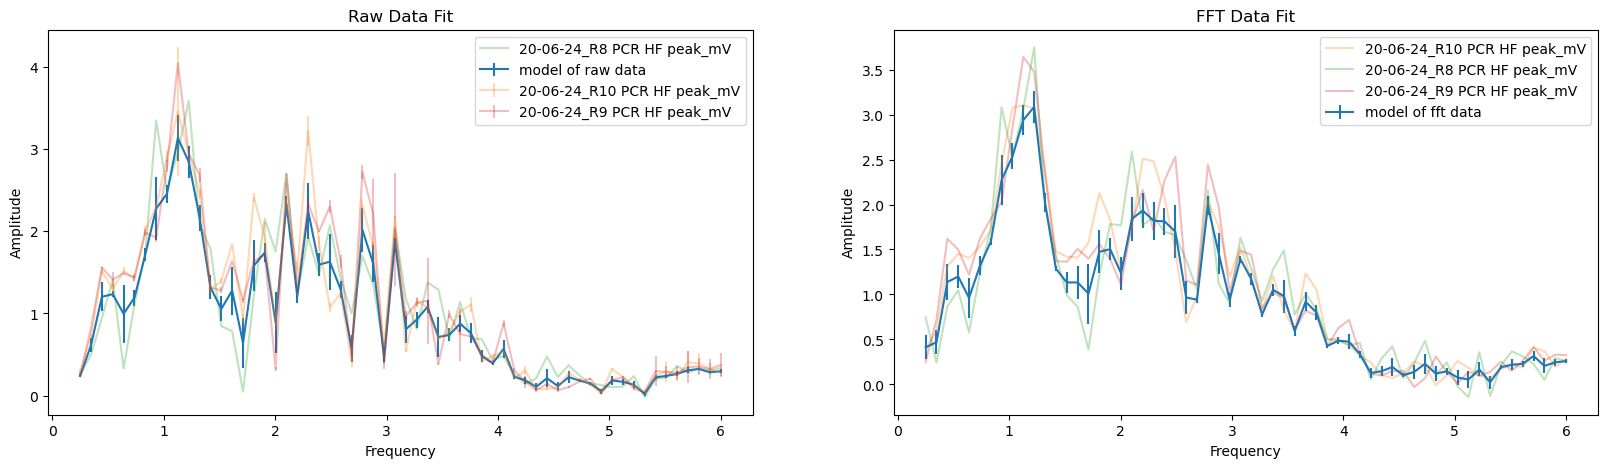

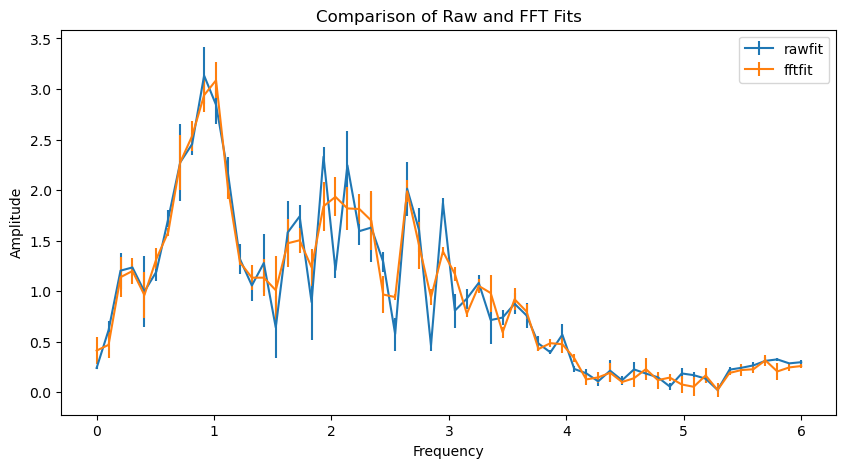

In [15]:
def TryToFitWithCorrelation():

    # RAW DATA
    #   get the data
    ids = ['20-06-24_R8', '20-06-24_R9','20-06-24_R10']
    rawdata = df[df['id'].isin(ids)]

    #   denoise data
    data = denoisePipe(rawdata)
    data = resamplePipe(data)

    #   minimize
    weights = [.3, .3, .3]
    def negcorr(weights, dataset):
        # here the dataset is fixed while the 
        # weights can change
        model = weightmean(dataset, weights)
        return -np.square(corrModelToData(dataset, model)).sum()
    
    res = minimize(negcorr, weights, data)
    print('nomal minimization weights: ', res['x'])
    print('correlation with the data: ', corrModelToData(data, weightmean(data, res['x'])))
    
    # FFT DENOISED DATA
    fft_data = denoisePipe(rawdata)
    fft_data = FFTFilterPipe(fft_data, 0.3, 8)
    fft_data = resamplePipe(fft_data)
    
    #   minimize
    weights = [.3, .3, .3]
    fftres = minimize(negcorr, weights, fft_data)
    print('fft filtering minimization weights: ', fftres['x'])
    print('correlation with the data: ', corrModelToData(fft_data, weightmean(fft_data, fftres['x'])))
    
    #   plot 
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs = axs.flatten()
    rawfit = weightmean(data, res['x'])
    axs[0].errorbar(data[data['id'] == ids[0]][k.freq], rawfit[0], yerr=rawfit[1], label='model of raw data')
    data.groupby('id').apply(plotThis, axs[0], alpha=0.3)
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_title('Raw Data Fit')
    axs[0].legend()
    
    #   plot 
    fftfit = weightmean(fft_data, fftres['x'])
    axs[1].errorbar(fft_data[fft_data['id'] == ids[0]][k.freq], fftfit[0], yerr=fftfit[1], label='model of fft data')
    fft_data.groupby('id').apply(plotThis, axs[1], alpha=0.3)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_title('FFT Data Fit')
    axs[1].legend()
   
    # togheter
    fig, ax = plt.subplots()
    x = np.linspace(0, 6, 60)
    plt.errorbar(x, rawfit[0], yerr=rawfit[1], label='rawfit')
    plt.errorbar(x, fftfit[0], yerr=fftfit[1], label='fftfit')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_title('Comparison of Raw and FFT Fits')
    ax.legend()
    
    print(f' correlation between the two models:\n {np.corrcoef(rawfit[0], fftfit[0])}')
    print('cross correlation fft with the data: ', corrModelToData(data, weightmean(fft_data, fftres['x'])))
    print('cross correlation normal with the fftdata: ', corrModelToData(fft_data, weightmean(data, res['x'])))
       
    return

TryToFitWithCorrelation()

Importante: abbiamo scelto di prendere misure a diverse frequenze, prendendo 60, poi 70 punti. L'idea era di avere più punti per rendere lo spettro più liscio ma si è rivelato uno sbaglio, perché la cosa più importante era fare statistica in quanto i nostri dati cambiano da misura a misura. Per poter confrontare tra loro i diversi campioni ho dovuto fare un *resampling* del campione a 70 punti a 60. La prossima volta sarebbe meglio ripetere la stessa misura tante volte per poter fare statistica in modo più opportuno.

In ogni caso dall'ultimo grafico si vede che i due risultati provenienti direttamente dai dati e poi dalla trasformata di fourier sono abbastanza simili a meno di alcuni punti in cui sono incompatibili, ad esempio a 2.8GHz.

Un'altra cosa importante è che si vede che il filtro fatto sulla trasformata di Fourier funziona: il modello generato dalla trasformata di fourier è più in accordo con il campione senza filtri che il viceversa. Questo potrebbe indicare il fatto che applicando il filtro si mantiene una coerenza con i dati reali.

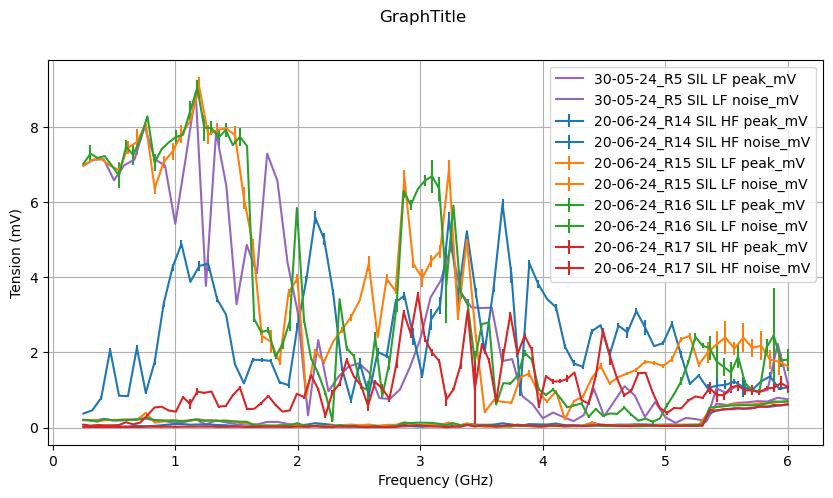

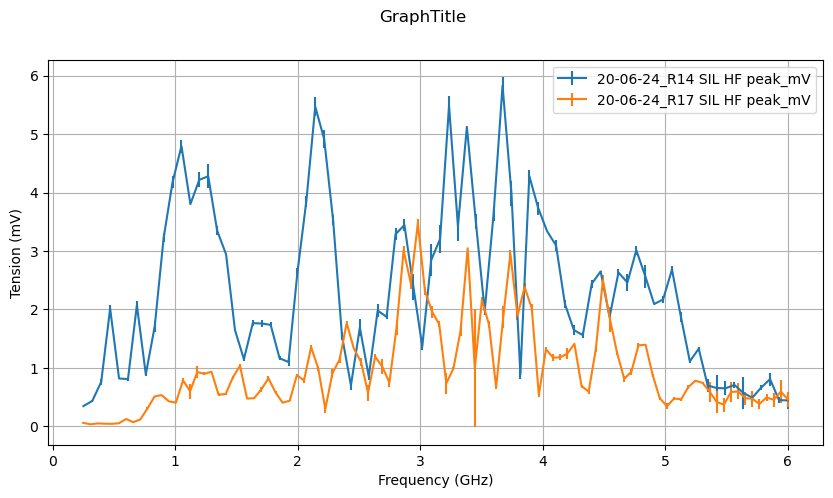

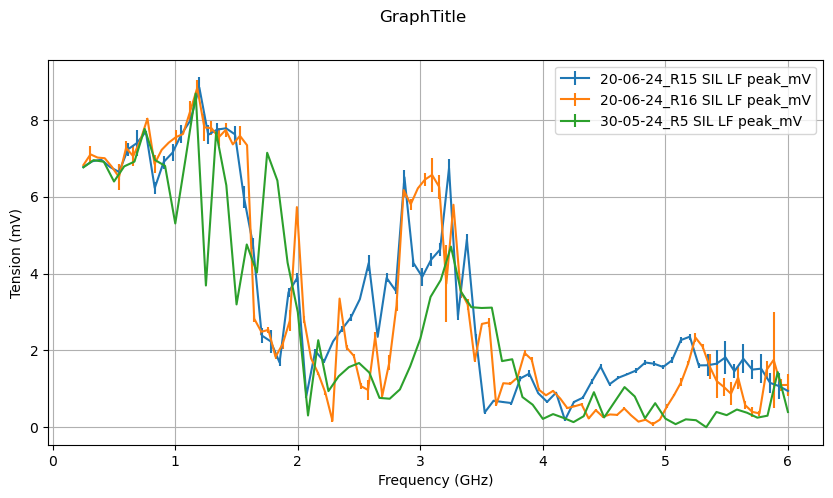

In [16]:
sil_rawdata = df[df['sample'] == 'SIL']

plotByID(sil_rawdata)

sil_data = denoisePipe(sil_rawdata)
plotByID(sil_data[sil_data['antenna'] == 'HF'])
plotByID(sil_data[sil_data['antenna'] == 'LF'])
